/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Successfully loaded plugin.


Generating Batch: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Test model...


Creating results table: 100%|██████████| 50/50 [00:00<00:00, 5386.71it/s]




      In order of most to least similar predictions compared to the actual parameters:

      Index   Total abs
       _______________
0000)  0000 : nan
0001)  0001 : nan
0002)  0002 : nan
0003)  0003 : nan
0004)  0004 : nan
0005)  0005 : nan
0006)  0006 : nan
0007)  0007 : nan
0008)  0008 : nan
0009)  0009 : nan
0010)  0010 : nan
0011)  0011 : nan
0012)  0012 : nan
0013)  0013 : nan
0014)  0014 : nan
0015)  0015 : nan
0016)  0016 : nan
0017)  0017 : nan
0018)  0018 : nan
0019)  0019 : nan
0020)  0020 : nan
0021)  0021 : nan
0022)  0022 : nan
0023)  0023 : nan
0024)  0024 : nan
0025)  0025 : nan
0026)  0026 : nan
0027)  0027 : nan
0028)  0028 : nan
0029)  0029 : nan
0030)  0030 : nan
0031)  0031 : nan
0032)  0032 : nan
0033)  0033 : nan
0034)  0034 : nan
0035)  0035 : nan
0036)  0036 : nan
0037)  0037 : nan
0038)  0038 : nan
0039)  0039 : nan
0040)  0040 : nan
0041)  0041 : nan
0042)  0042 : nan
0043)  0043 : nan
0044)  0044 : nan
0045)  0045 : nan
0046)  0046 : nan
0047)  0047 : nan

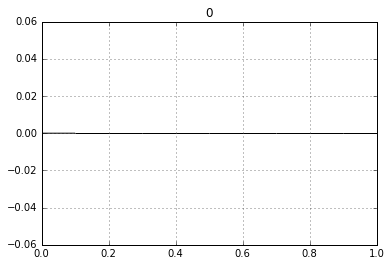

In [1]:
from utils import PluginFeatureExtractor
import tensorflow as tf
import numpy as np
from tqdm import trange
import IPython
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.ops import rnn, rnn_cell

extractor = PluginFeatureExtractor(midi_note=24, note_length_secs=0.8,
                                   render_length_secs=1.8,
                                   pickle_path="normalisers/",
                                   warning_mode="ignore")

path = "/home/tollie/Development/vsts/dexed/Builds/Linux/build/Dexed.so"
extractor.load_plugin(path)

if extractor.need_to_fit_normalisers():
    extractor.fit_normalisers(10000)

(features, parameters) = extractor.get_random_normalised_example()

learning_rate = 0.001
training_iters = 2000000
batch_size = 50
display_step = 1
save_step = 20
number_hidden = 40
number_layers = 3
number_input = int(features.shape[1])
number_timesteps = int(features.shape[0])
number_outputs = len(parameters)

x = tf.placeholder("float", [None, number_timesteps, number_input], name="Features")
y = tf.placeholder("float", [None, number_outputs], name="Synth_Patch")

# Create model
def RNN(x, weights, biases):
    # Prepare data shape to match rnn function requirements.
    # Current data input shape: (batch_size, number_timesteps, number_input)
    # Required shape: (number_timesteps, batch_size, number_input)
    tr_x = tf.transpose(x, [1, 0, 2])
    re_x = tf.reshape(tr_x, [-1, number_input])
    sp_x = tf.split(0, number_timesteps, re_x)

    # embeddings = tf.get_variable('embedding_matrix', [number_outputs, number_hidden])
    # lstm_inputs = tf.nn.embedding_lookup(embeddings, x)

    lstm_cell = rnn_cell.LSTMCell(number_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell = rnn_cell.MultiRNNCell([lstm_cell] * number_layers, state_is_tuple=True)
    init_state = lstm_cell.zero_state(batch_size, tf.float32)
    outputs, states = rnn.rnn(cell=lstm_cell, inputs=sp_x, dtype=tf.float32, initial_state=init_state)

    # Linear activation using rnn inner loop last output
    return tf.add(tf.matmul(outputs[-1], weights['out']), biases['out'])

def init_weights(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)

# Store layers weight & bias
weights = {
    'out': init_weights([number_hidden, number_outputs], "weights_out")
}
biases = {
    'out': init_weights([number_outputs], "biases_out")
}

tf.summary.histogram("out", weights['out'])

# Construct model
prediction = RNN(x, weights, biases)

# Add ops to save and restore all variables.
saver = tf.train.Saver()

(f, p) = extractor.get_random_normalised_example()
f_shape = np.array(f).shape

batch_x = np.zeros((batch_size, f_shape[0], f_shape[1]), dtype=np.float32)
batch_y = np.zeros((batch_size, p.shape[0]), dtype=np.float32)

# Launching the graph.
with tf.Session() as sess:

    # Restore variables from disk.
    saver.restore(sess, "models/deep_rnn_model.ckpt")

    for i in trange(batch_size, desc="Generating Batch"):
        (features, parameters) = extractor.get_random_normalised_example()
        batch_x[i] = features
        batch_y[i] = parameters

    print "Test model..."

    pred = sess.run([prediction], feed_dict={ x: batch_x,
                                              y: batch_y })
    all_tests = []

    for i in trange(len(pred[0]), desc="Creating results table"):
        total_abs = 0

        for param in range(len(pred[0][0])):
            pred_param = pred[0][i][param]
            actual_param = batch_y[i][param]
            # print actual_param
            total_abs += abs(pred_param - actual_param)

        absolute_distance_table = " " +("%04d" % i) + " : " + ("%.5f" % round(total_abs, 5))
        all_tests.append((total_abs, absolute_distance_table, pred[0][i], batch_y[i]))

    all_tests.sort(key=lambda x: x[0])

    print "\n\n      In order of most to least similar predictions compared to the actual parameters:\n\n      Index   Total abs"
    print "       _______________"
    for i in range(len(all_tests)):
        print ("%04d" % i) + ") " + all_tests[i][1]

    def add_patch_indices(patch):
        tuple_patch = []
        for i in range(len(patch)):
            tuple_patch += [(i, float(patch[i]))]
        return tuple_patch
    
    import pandas as pd
    df = pd.DataFrame([float(test[1][7:]) for test in all_tests])
    df.hist()


    
        


## PLEASE NOTE:-
When you look at the predictions shortly after the next cell, you'll see the model is predicting very similar patches. This next cell proves they aren't exactly the same; the code is not inccorrectly storing tests - they are actually just very similar predictions with incredibly small floating point differences element-wise.

In [3]:
first_patch_prediction = all_tests[0][2]
second_patch_prediction = all_tests[1][2]

assert (first_patch_prediction - first_patch_prediction).all() == 0
assert (first_patch_prediction - second_patch_prediction).all() != 0

AssertionError: 

# Best Prediction

In [5]:
i = 0

patch_predicted = add_patch_indices(all_tests[i][2])
patch_actual = add_patch_indices(all_tests[i][3])

### Predicted

0_pred.wav


/usr/lib/python2.7/dist-packages/matplotlib/colors.py:941: UserWarning: Warning: converting a masked element to nan.
  vmin = float(vmin)
/usr/lib/python2.7/dist-packages/matplotlib/colors.py:942: UserWarning: Warning: converting a masked element to nan.
  vmax = float(vmax)


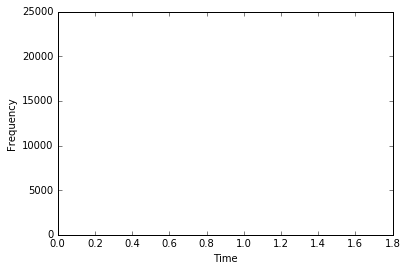

In [6]:
extractor.set_patch(patch_predicted)
x = extractor.get_audio_frames()
file_name = str(i) + "_pred.wav"
print file_name

# Plot a spectrogram
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [7]:
IPython.display.Audio(x, rate=44100)

### Actual

0_actual.wav


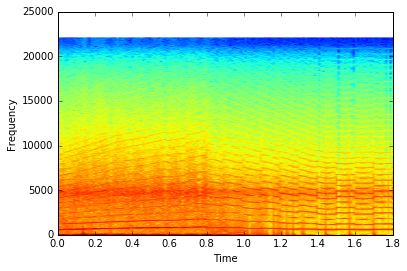

In [6]:
extractor.set_patch(patch_actual)
x = extractor.get_audio_frames()
file_name = str(i) + "_actual.wav"
print file_name

IPython.display.Audio(extractor.get_audio_frames(), rate=44100)
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')

In [7]:
IPython.display.Audio(x, rate=44100)

# Second Best Prediction

In [8]:
i = 1

patch_predicted = add_patch_indices(all_tests[i][2])
patch_actual = add_patch_indices(all_tests[i][3])

### Prediction

1_pred.wav


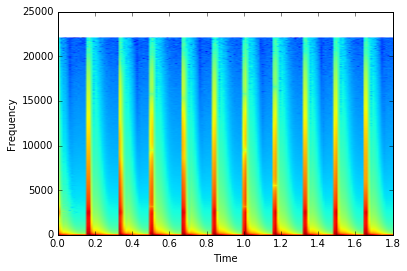

In [9]:
extractor.set_patch(patch_predicted)
x = extractor.get_audio_frames()
file_name = str(i) + "_pred.wav"
print file_name

# Plot a spectrogram
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [10]:
IPython.display.Audio(x, rate=44100)

### Actual

1_actual.wav


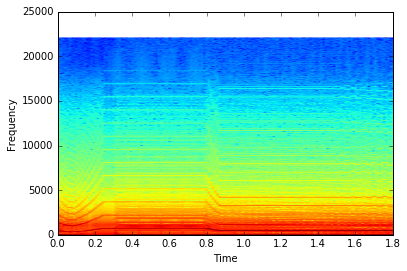

In [11]:
extractor.set_patch(patch_actual)
x = extractor.get_audio_frames()
file_name = str(i) + "_actual.wav"
print file_name

IPython.display.Audio(extractor.get_audio_frames(), rate=44100)
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')

In [12]:
IPython.display.Audio(x, rate=44100)

# Third Best Prediction

In [13]:
i = 2

patch_predicted = add_patch_indices(all_tests[i][2])
patch_actual = add_patch_indices(all_tests[i][3])

### Predicted

2_pred.wav


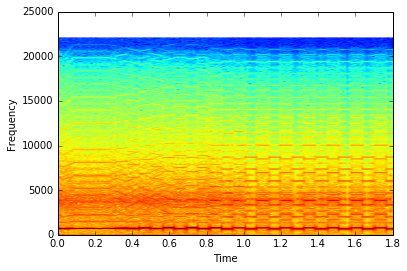

In [14]:
extractor.set_patch(patch_predicted)
x = extractor.get_audio_frames()
file_name = str(i) + "_pred.wav"
print file_name

# Plot a spectrogram
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [15]:
IPython.display.Audio(x, rate=44100)

### Actual

2_actual.wav


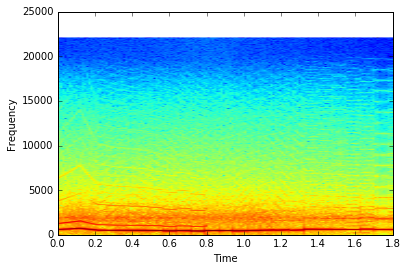

In [16]:
extractor.set_patch(patch_actual)
x = extractor.get_audio_frames()
file_name = str(i) + "_actual.wav"
print file_name

IPython.display.Audio(extractor.get_audio_frames(), rate=44100)
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')

In [17]:
IPython.display.Audio(x, rate=44100)

# Worst Prediction

In [18]:
i = 49

patch_predicted = add_patch_indices(all_tests[i][2])
patch_actual = add_patch_indices(all_tests[i][3])

### Predicted

49_pred.wav


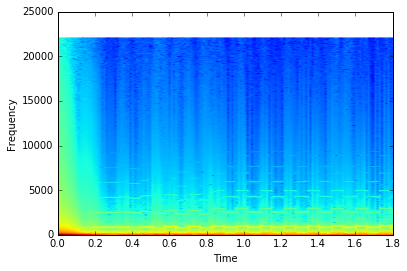

In [19]:
extractor.set_patch(patch_predicted)
x = extractor.get_audio_frames()
file_name = str(i) + "_pred.wav"
print file_name

# Plot a spectrogram
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [20]:
IPython.display.Audio(x, rate=44100)

### Actual

49_actual.wav


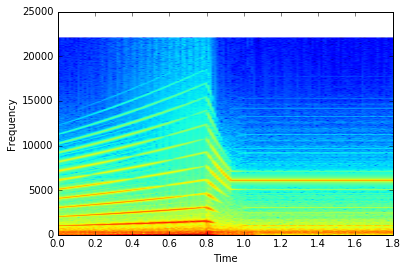

In [21]:
extractor.set_patch(patch_actual)
x = extractor.get_audio_frames()
file_name = str(i) + "_actual.wav"
print file_name

IPython.display.Audio(extractor.get_audio_frames(), rate=44100)
plt.specgram(x, NFFT=1024, Fs=44100, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')

In [22]:
IPython.display.Audio(x, rate=44100)